In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from datetime import date


In [124]:
# Training Dataset
# expedia = pd.read_csv('../Final_Project/data/train.csv',nrows=500000)
expedia = pd.read_csv('../Final_Project/data/train.csv',nrows=150000)

In [125]:
print 'Expedia Site Dataframe Shape'
print expedia.shape

Expedia Site Dataframe Shape
(150000, 24)


In [126]:
# Add features that are added when training
# Prep Expedia Train Dataset 
# Add a column for the epoch time to dataset. 
# Need to do this before time is changed from a string to a date time
import time, os
# search time epoch
epochs = []
d = expedia.date_time
p='%Y-%m-%d %H:%M:%S'
for dts in d:
    epoch = int(time.mktime(time.strptime(dts,p)))
    epochs.append(epoch)
expedia['search_time_epoch'] = epochs


# time on site column
# using time the user first searched as t0. i.e. 0 time = first search
expedia['tos'] = expedia.search_time_epoch
user = expedia.user_id
for u in user: 
    t0 = min(expedia.loc[expedia.user_id == u].search_time_epoch)
    expedia.loc[expedia['user_id']==u,'tos'] = expedia.search_time_epoch - t0


In [127]:
book = expedia['is_booking'] == 1
# Select all cases where stark is the attacker and the attacker wins
expedia_booked = expedia[book]

# expedia = expedia[expedia.is_booking == 1]
# expedia = expedia.loc[expedia.is_booking == 1]
print 'Expedia Training when isbooking = 1'
print expedia_booked.shape

Expedia Training when isbooking = 1
(12488, 26)


In [128]:
# user IDs. 
print 'Dataset Stats'
print 'Size of Dataframe', expedia.shape

# unique User counts. 
user = expedia.groupby('user_id').user_id.count()
muser = user.mean()
print 'Unique Users: ', len(user)
print 'Mean entries per user: ', muser

# Number of bookings vs. other entries. 
lbook = len(expedia.loc[(expedia['is_booking']  == 1)])
num_book = expedia.groupby('is_booking').is_booking.count()
print 'Number of entries where users book', lbook, 'total', len(expedia)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_cluster').hotel_cluster.count()
print 'Unique Hotel Cluster IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_continent').hotel_cluster.count()
print 'Unique Hotel Continents IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_country').hotel_cluster.count()
print 'Unique Hotel Country IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia.groupby('hotel_market').hotel_cluster.count()
print 'Unique Hotel Market IDs: ', len(hc)

Dataset Stats
Size of Dataframe (150000, 26)
Unique Users:  5142
Mean entries per user:  29.1715285881
Number of entries where users book 12488 total 150000
Unique Hotel Cluster IDs:  100
Unique Hotel Continents IDs:  6
Unique Hotel Country IDs:  165
Unique Hotel Market IDs:  1670


In [129]:
# unique User counts. 
user = expedia_booked.groupby('user_id').user_id.count()
muser = user.mean()
print 'Unique Users: ', len(user)
print 'Mean entries per user: ', muser

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_cluster').hotel_cluster.count()
print 'Unique Hotel Cluster IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_continent').hotel_cluster.count()
print 'Unique Hotel Continents IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_country').hotel_cluster.count()
print 'Unique Hotel Country IDs: ', len(hc)

# unique hotel cluster counts. 
hc = expedia_booked.groupby('hotel_market').hotel_cluster.count()
print 'Unique Hotel Market IDs: ', len(hc)


Unique Users:  3439
Mean entries per user:  3.63128816516
Unique Hotel Cluster IDs:  100
Unique Hotel Continents IDs:  6
Unique Hotel Country IDs:  137
Unique Hotel Market IDs:  1234


In [130]:
# Add features 
# define function to find the day of the week. 
# Monday = 1, Sunday = 7
def find_dow(date_col):
    dow = []
    for d in date_col: 
        dow.append(d.isoweekday()) 
    return dow


# Adding Time Feature columns to Dataset 

# Replacing NaN/None values in check in and out search. 
expedia_booked['srch_ci'] = np.where(pd.isnull(expedia_booked.srch_ci) == 1, 0, expedia_booked.srch_ci)
expedia_booked['srch_co'] = np.where(pd.isnull(expedia_booked.srch_co) == 1, 0, expedia_booked.srch_co)

expedia_booked['date_time'] = pd.to_datetime(expedia['date_time'])
expedia_booked['year'] = expedia_booked['date_time'].dt.year
expedia_booked['month'] = expedia_booked['date_time'].dt.month
expedia_booked['day'] = expedia_booked['date_time'].dt.day

# -------------------
# Adding Day of the week the search occured
# Monday = 1, Sunday = 7
date_time = expedia_booked.date_time
dow = find_dow(date_time)
expedia_booked['dow_search'] = dow

# -------------------
# Adding Day of the week check-in date
expedia_booked['srch_ci'] = pd.to_datetime(expedia_booked['srch_ci'])
date_ci = expedia_booked.srch_ci
dow = find_dow(date_ci)
expedia_booked['dow_ci'] = dow

# -------------------
# Adding Day of the week check-out date
expedia_booked['srch_co'] = pd.to_datetime(expedia_booked['srch_co'])
date_co = expedia_booked.srch_co
dow = find_dow(date_co)
expedia_booked['dow_co'] = dow

# -------------------
# length of stay in days
delta = date_co - date_ci
los = np.zeros(len(delta))
c = 0
for d in delta:
    los[c] = d.days
    c += 1    
expedia_booked['length_of_stay'] = los

# Adding feature columns to dataset. 

# if there are children - making a binary column of family
is_family = np.where(expedia_booked.srch_children_cnt >= 1, 1, 0)
expedia_booked['is_family'] = is_family

# expedia.head(2)

/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mcullen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [131]:
# add features from detinations csv

destinations = pd.read_csv('../Final_Project/data/destinations.csv') 

# Prep Destinations Dataset
# Adding Mean, Meadian, stdev, is_positive columns 
d = destinations
d = d.drop('srch_destination_id',axis = 1)

destinations['mean_latent'] = np.nanmean(d, axis=1)
destinations['median_latent'] = np.nanmedian(d, axis=1)
destinations['std_latent'] = np.nanstd(destinations, axis=1)
destinations['mean_p_std_latent'] = abs(destinations.mean_latent) + destinations.std_latent
destinations['max_latent'] = np.nanmax(d, axis=1)
destinations['min_latent'] = np.nanmin(d, axis=1)
destinations['is_positive_review'] = np.where(destinations.mean_latent > 0, 1, 0)
destinations['range_latent'] = destinations.max_latent - destinations.min_latent

# use only summary columns in training. 
use = ['srch_destination_id', 'mean_latent', 'median_latent', 'std_latent',\
       'mean_p_std_latent', 'max_latent', 'min_latent','is_positive_review',\
       'range_latent']
destinations_use =  destinations[use]


# Add Destination Data Information to Expedia Dataset
# Adding by search destination ID
expedia_booked = pd.merge(expedia_booked, destinations_use, left_on='srch_destination_id', \
                   right_on='srch_destination_id', how='left')


In [132]:
# fix NaN and Null values
expedia_booked['mean_latent'] = np.where(pd.isnull(expedia_booked.mean_latent) == 1, 0, expedia_booked.mean_latent)
expedia_booked['median_latent'] = np.where(pd.isnull(expedia_booked.median_latent) == 1, 0, expedia_booked.median_latent)
expedia_booked['std_latent'] = np.where(pd.isnull(expedia_booked.std_latent) == 1, 0, expedia_booked.std_latent)
expedia_booked['mean_p_std_latent'] = np.where(pd.isnull(expedia_booked.mean_p_std_latent) == 1, 0, expedia_booked.mean_p_std_latent)
expedia_booked['max_latent'] = np.where(pd.isnull(expedia_booked.max_latent) == 1, 0, expedia_booked.max_latent)
expedia_booked['min_latent'] = np.where(pd.isnull(expedia_booked.min_latent) == 1, 0, expedia_booked.min_latent)
expedia_booked['is_positive_review'] = np.where(pd.isnull(expedia_booked.is_positive_review) == 1, 0, expedia_booked.is_positive_review)
expedia_booked['range_latent'] = np.where(pd.isnull(expedia_booked.range_latent) == 1, 0, expedia_booked.range_latent)

# print expedia_booked.shape
# expedia_booked.head(2)

In [133]:
expedia.corr()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,search_time_epoch,tos
site_name,1.000000,-0.762252,0.112262,0.304785,0.011985,0.056528,0.005670,-0.017808,0.113560,-0.063227,...,0.018824,-0.043969,-0.018948,0.022977,0.259222,0.244264,-0.060917,-0.018816,0.021199,-0.138609
posa_continent,-0.762252,1.000000,0.141164,-0.252425,-0.015983,-0.028654,0.010819,0.012985,-0.144780,0.089469,...,-0.018312,0.058189,0.017203,-0.019533,-0.351970,-0.176100,0.051691,0.003910,-0.034799,0.123107
user_location_country,0.112262,0.141164,1.000000,0.005410,0.103069,0.057937,0.020328,0.000621,-0.012581,0.078098,...,-0.007001,0.010707,0.002077,0.011646,-0.037428,0.134846,0.010436,-0.023095,-0.040366,-0.002668
user_location_region,0.304785,-0.252425,0.005410,1.000000,0.082451,0.061233,0.046459,-0.008230,0.056263,-0.022798,...,0.014633,-0.007376,0.010695,-0.001343,0.118600,-0.016786,0.043072,0.009713,-0.032451,0.001309
user_location_city,0.011985,-0.015983,0.103069,0.082451,1.000000,-0.005216,-0.042118,-0.017850,0.033613,0.005582,...,0.001054,-0.010876,-0.000009,-0.003016,0.005250,-0.000454,0.007463,-0.000566,0.000238,-0.009675
orig_destination_distance,0.056528,-0.028654,0.057937,0.061233,-0.005216,1.000000,0.004780,-0.060148,0.056159,0.012882,...,-0.009122,-0.046050,-0.038664,0.028773,0.482533,0.298655,-0.076359,0.010967,-0.016085,0.009614
user_id,0.005670,0.010819,0.020328,0.046459,-0.042118,0.004780,1.000000,0.000384,-0.001172,0.003040,...,-0.006014,-0.004889,0.003558,0.003856,-0.036742,-0.013657,0.006631,-0.007737,-0.001735,0.004966
is_mobile,-0.017808,0.012985,0.000621,-0.008230,-0.017850,-0.060148,0.000384,1.000000,0.061960,-0.049578,...,-0.024317,-0.022956,-0.033912,0.002874,-0.009106,-0.022734,-0.005439,0.001481,0.039121,-0.006902
is_package,0.113560,-0.144780,-0.012581,0.056263,0.033613,0.056159,-0.001172,0.061960,1.000000,-0.026841,...,-0.144829,-0.223937,-0.080038,0.119911,0.128585,-0.008436,-0.000929,0.054928,-0.001185,-0.040263
channel,-0.063227,0.089469,0.078098,-0.022798,0.005582,0.012882,0.003040,-0.049578,-0.026841,1.000000,...,-0.005454,0.031548,0.028666,-0.014851,-0.021900,-0.021977,0.022935,-0.003678,-0.063260,0.036913


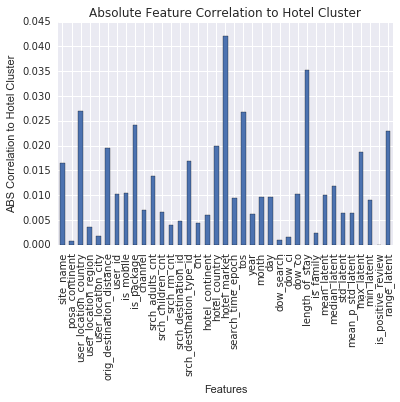

In [134]:
corrs = expedia_booked.corr()
corrs = corrs.drop(['hotel_cluster','is_booking'],axis = 0)
corrs['hotel_cluster_abs'] = corrs.hotel_cluster.abs()
# corrs = corrs.abs()
corrs.hotel_cluster_abs.plot(kind='bar', title='Absolute Feature Correlation to Hotel Cluster')
plt.xlabel('Features')
plt.ylabel('ABS Correlation to Hotel Cluster')

In [135]:
# pd.scatter_matrix(expedia_booked, figsize = (10,10))

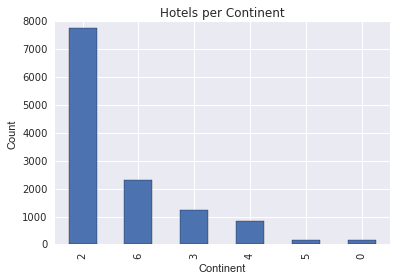

In [136]:
# bar plot of number of Hotels in each continent
expedia_booked.hotel_continent.value_counts().plot(kind='bar', title='Hotels per Continent')
plt.xlabel('Continent')
plt.ylabel('Count')

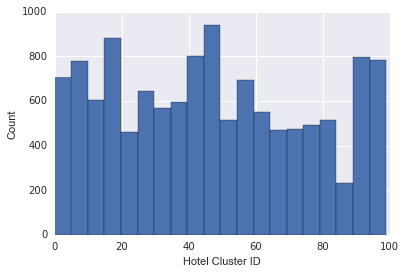

In [137]:
# histogram of beer servings
expedia_booked.hotel_cluster.hist(bins=20)
plt.xlabel('Hotel Cluster ID')
plt.ylabel('Count')

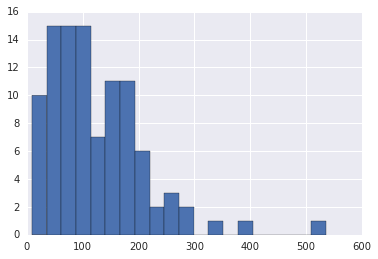

In [138]:
expedia_booked.hotel_cluster.value_counts().hist(bins=20)


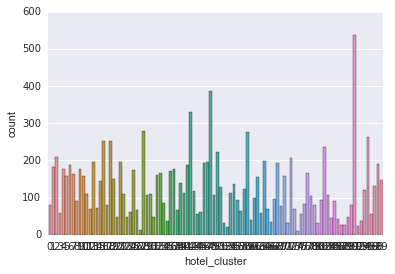

In [139]:
sns.countplot(x='hotel_cluster', data=expedia_booked)

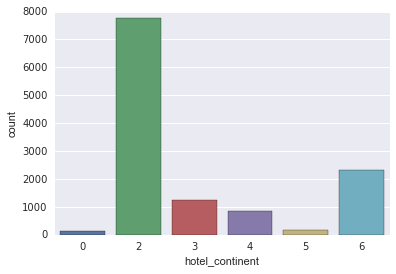

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt
# preferred continent destinations
sns.countplot(x='hotel_continent', data=expedia_booked)

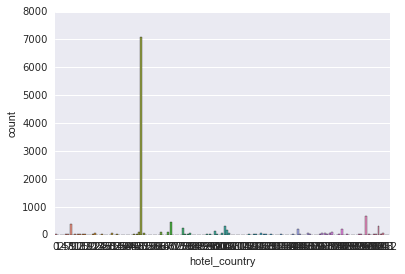

In [141]:
sns.countplot(x='hotel_country', data=expedia_booked)

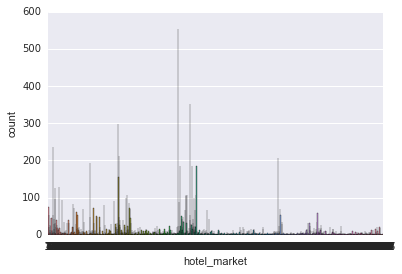

In [142]:
sns.countplot(x='hotel_market', data=expedia_booked)

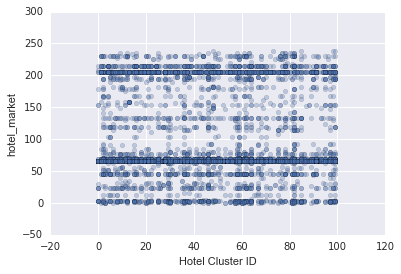

In [143]:
# scatterplot of hotel cluster  versus 
expedia_booked.plot(x='hotel_cluster', y='user_location_country', kind='scatter', alpha=0.3)
plt.xlabel('Hotel Cluster ID')
plt.ylabel('hotel_market')